In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('traffic.csv')
df

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


In [21]:
time_series=df['Junction']
result = adfuller(time_series)
print('ADF Statistic:', result[0])
print('p-value: ',result[1])
print('Critical Values: ',result[4])

if result[1] <= 0.05:
    print('Reject the null hypothesis. The data is stationary.')
else:
    print('Fall to reject the null hypothesis.The data is non-stationary')

ADF Statistic: -0.3233541182095162
p-value:  0.9221309443842827
Critical Values:  {'1%': -3.4304859057519437, '5%': -2.8616000674994804, '10%': -2.5668019719523705}
Fall to reject the null hypothesis.The data is non-stationary


In [4]:
data = df['Vehicles'].values.reshape(-1, 1)


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [6]:
def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

In [7]:
time_steps = 3 

In [8]:
X, Y = create_dataset(data_scaled, time_steps)


In [9]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))


In [10]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, time_steps)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
history=model.fit(X, Y, epochs=25, batch_size=32,validation_split=0.1)
history

Epoch 1/25
1354/1354 [==============================] - 4s 3ms/step - loss: 7.3932e-04 - val_loss: 4.9065e-04
Epoch 2/25
1354/1354 [==============================] - 4s 3ms/step - loss: 7.3900e-04 - val_loss: 4.7427e-04
Epoch 3/25
1354/1354 [==============================] - 4s 3ms/step - loss: 7.3589e-04 - val_loss: 5.4701e-04
Epoch 4/25
1354/1354 [==============================] - 4s 3ms/step - loss: 7.3962e-04 - val_loss: 4.8734e-04
Epoch 5/25
1354/1354 [==============================] - 4s 3ms/step - loss: 7.3698e-04 - val_loss: 4.8705e-04
Epoch 6/25
1354/1354 [==============================] - 4s 3ms/step - loss: 7.3669e-04 - val_loss: 4.9206e-04
Epoch 7/25
1354/1354 [==============================] - 4s 3ms/step - loss: 7.3706e-04 - val_loss: 4.8489e-04
Epoch 8/25
1354/1354 [==============================] - 4s 3ms/step - loss: 7.3548e-04 - val_loss: 4.8275e-04
Epoch 9/25
1354/1354 [==============================] - 3s 3ms/step - loss: 7.3489e-04 - val_loss: 5.0815e-04
Epoch 10/2

In [37]:
print(history.history.keys())


dict_keys(['loss', 'val_loss'])


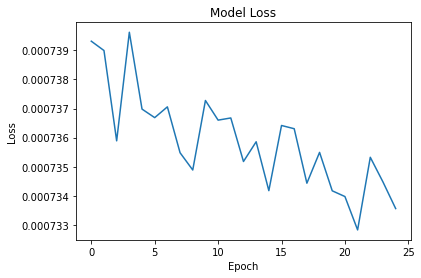

In [41]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
test_input = data_scaled[-time_steps:]
test_input = np.reshape(test_input, (1, 1, time_steps))
predicted_vehicle_count_scaled = model.predict(test_input)

1/1 [==============================] - 0s 448ms/step


In [13]:
predicted_vehicle_count = scaler.inverse_transform(predicted_vehicle_count_scaled)

print("Predicted Vehicle Count:", predicted_vehicle_count[0, 0])

predicted_scaled = model.predict(X)

Predicted Vehicle Count: 14.37401
1504/1504 [==============================] - 2s 1ms/step


In [14]:
predicted = scaler.inverse_transform(predicted_scaled)


In [15]:
actual = scaler.inverse_transform(Y.reshape(-1, 1))


In [16]:
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
rmse = np.sqrt(mean_squared_error(actual, predicted))
mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
print("MAPE:", mape)
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

MAPE: 27.942605447949227
RMSE: 5.259055297762285
MSE: 27.657662624921553
MAE: 3.6376456502251098


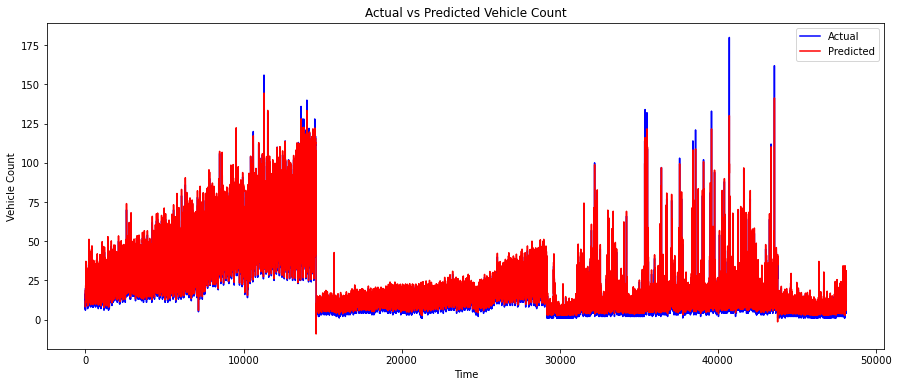

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(actual, label='Actual', color='blue')
plt.plot(predicted, label='Predicted', color='red')
plt.title('Actual vs Predicted Vehicle Count')
plt.xlabel('Time')
plt.ylabel('Vehicle Count')
plt.legend()
plt.show()
